In [65]:
import tensorflow as tf 
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import Common_Functions as cf 
from mpl_toolkits import mplot3d
plt.rc('font', family='serif')
import matplotlib
matplotlib.rcParams.update({'font.size': 12})

In [ ]:
#Empty GPU Memory
cf.reset()

2021-11-30 14:30:44.590629: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-30 14:30:44.590949: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-30 14:30:44.591195: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-30 14:30:44.591447: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-30 14:30:44.591653: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

In [48]:
#Load Data
df_pions = np.array(pd.read_csv('/home/sean/Documents/Work/Level 4/Level-4-Masters-Project/testing_data.csv',header = None))
#Hold Out Validation
train_x, train_y = df_pions[:-1000,:-1], df_pions[:-1000,-1]
val_x, val_y = df_pions[-1000:,:-1], df_pions[-1000:,-1]

In [49]:
#Adam Optimiser
opt = keras.optimizers.Adam( amsgrad= True)

In [50]:
## Function Creates multiple Identical networks while varying batch size.
## Returns numpy array of Batch sizes 
## Returns numpy array of min MAPE of size len(batch_size),repeats
def batch_size_tester(batch_size_range,step = 2,repeats = 5,section = None):
    batch_size_min, batch_size_max = batch_size_range
    batch_size_max = batch_size_max+1 ##Indexing trick so that the last batch size value is included 
    batch_sizes = np.arange(batch_size_min,batch_size_max,step = step)
    min_mape = np.zeros((len(batch_sizes),repeats))
    for i,_ in enumerate(batch_sizes):
        print('Batch Size ',batch_sizes[i])
        for j in range(repeats):
            mape_df = cf.trained_network(train_x[:section],train_y[:section],val_x,val_y,[512,512,512], optimizer= opt, verbose= 0,batch_size = batch_sizes[i]).history['val_mean_absolute_percentage_error']
            min_mape[i,j] = np.min(mape_df)
    return min_mape, batch_sizes

In [58]:
min_mape, batch_sizes = batch_size_tester((4,500),step = 16, repeats= 10)

Batch Size  4
Batch Size  20
Batch Size  36
Batch Size  52
Batch Size  68
Batch Size  84
Batch Size  100
Batch Size  116
Batch Size  132
Batch Size  148
Batch Size  164
Batch Size  180
Batch Size  196
Batch Size  212
Batch Size  228
Batch Size  244
Batch Size  260
Batch Size  276
Batch Size  292
Batch Size  308
Batch Size  324
Batch Size  340
Batch Size  356
Batch Size  372
Batch Size  388
Batch Size  404
Batch Size  420
Batch Size  436
Batch Size  452
Batch Size  468
Batch Size  484
Batch Size  500


In [59]:
#Calculation of plotting quantities
mean_min_mape = np.mean(min_mape,axis= 1)
std_min_mape = np.std(min_mape,axis= 1)
mse = std_min_mape/min_mape.shape[1]**0.5

Text(0, 0.5, 'Mean Minimum MAPE')

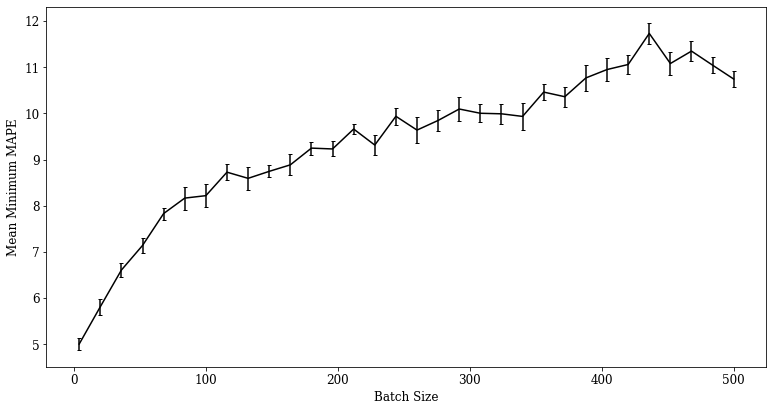

In [66]:
#plotting
fig = plt.figure(figsize= (10,5))
ax = fig.add_axes((0,0,1,1))
ax.errorbar(batch_sizes,mean_min_mape,mse,color = 'black',capsize= 2)
ax.set_xlabel('Batch Size')
ax.set_ylabel('Mean Minimum MAPE')


In [64]:
fig.savefig('/home/sean/Documents/Work/Level 4/Level-4-Masters-Project/Figures/Batch_size.png',dpi = 300)